In [1]:
import pickle
import pandas as pd
from CITEsort_rna.BTreeTraversal import BTreeTraversal
from CITEsort_rna.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
from metadimm import MetaDIMM

## load data and tree 

In [101]:
id='5_4'

# adata= sc.read_h5ad('../SeuratV3/subdata/'+id+'_RNA.h5ad')
# label = adata.obs['label']
# label.name = 'cell_type'

# adata = sc.read_h5ad('../simulator_out/RNA_simulator_'+id+'.h5ad')
# ct_list = ['CD4 Naive','CD8 Naive','CD14 Mono']
# adata = adata[adata.obs['label_l2'].isin(ct_list),:]
# adata = sc.read_h5ad('./output/rna/CD4_CD8_Naive_CD14_Mono/adata_pp.h5ad')
# id='3_2'
f = open('../output/'+id+'_rna/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()

traversal = BTreeTraversal(tree)

In [92]:

md = MetaDIMM()
adata = adata[tree.indices,:]
# adata = md.filter(adata)
adata = md.preprocess(adata, normalize=True, log1p=True, hvg=True, scale=False)

# label = pd.read_csv('../simulator_out/droplets_composition_'+id+'.csv')
# label.index = label.iloc[:,0]
adata.obs['label'] = label#['cell_type'].astype(str)

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


---------------------------------------
Function 'preprocess' executed in 5.18s
---------------------------------------


## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [4]:
# visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


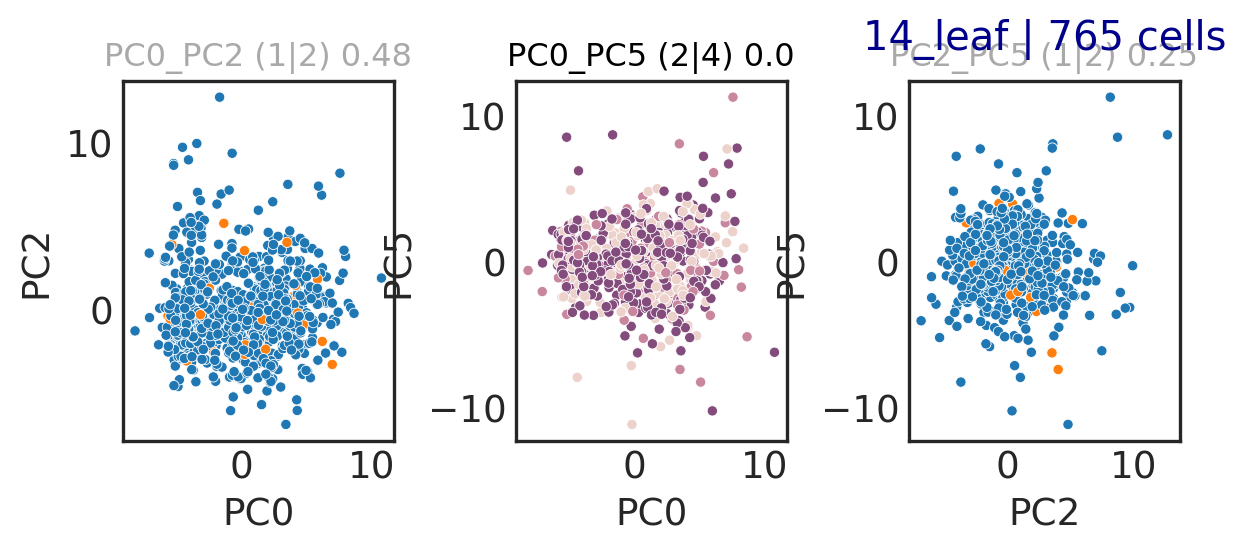

In [98]:
node_ID = 14
traversal.plot_node(adata,node_ID,viz_dim=2,savefig=False)

In [99]:
node = traversal.get_node(14)
# node.all_clustering_dic[2].keys()#[('PC2',)]['bp_pro']*len(node.indices)
# len(node.indices)
node.stop

'no separable features'

In [23]:
import numpy as np
import pandas as pd
def outlier_filter(data):

    iqr = data.quantile([0.25,0.5,0.75])
    iqr.loc['iqr',:] = (iqr.loc[0.75,:] - iqr.loc[0.25,:])*1.5
    iqr.loc['min',:] = iqr.loc[0.25,:]-iqr.loc['iqr',:]
    iqr.loc['max',:] = iqr.loc[0.75,:]+iqr.loc['iqr',:]
    index = set(data.index)
    flag = False
    for col in iqr.columns:
        xmax, xmin = max(data.loc[:,col]), min(data.loc[:,col])
        if xmax-xmin > 5*iqr.loc['iqr',col]:
            flag = True
        if xmax-xmin < 3*iqr.loc['iqr',col]:
            continue
        index = index & set(data[data.loc[:,col]<iqr.loc['max',col]].index) & set(data[data.loc[:,col]>iqr.loc['min',col]].index)
        if len(data)-len(index) > 20:
            # index = set(data.index) - set(data[col].iloc[[np.argmax(list(data.loc[:,col])),np.argmin(list(data.loc[:,col]))]].index)
            break  
    return list(index), flag

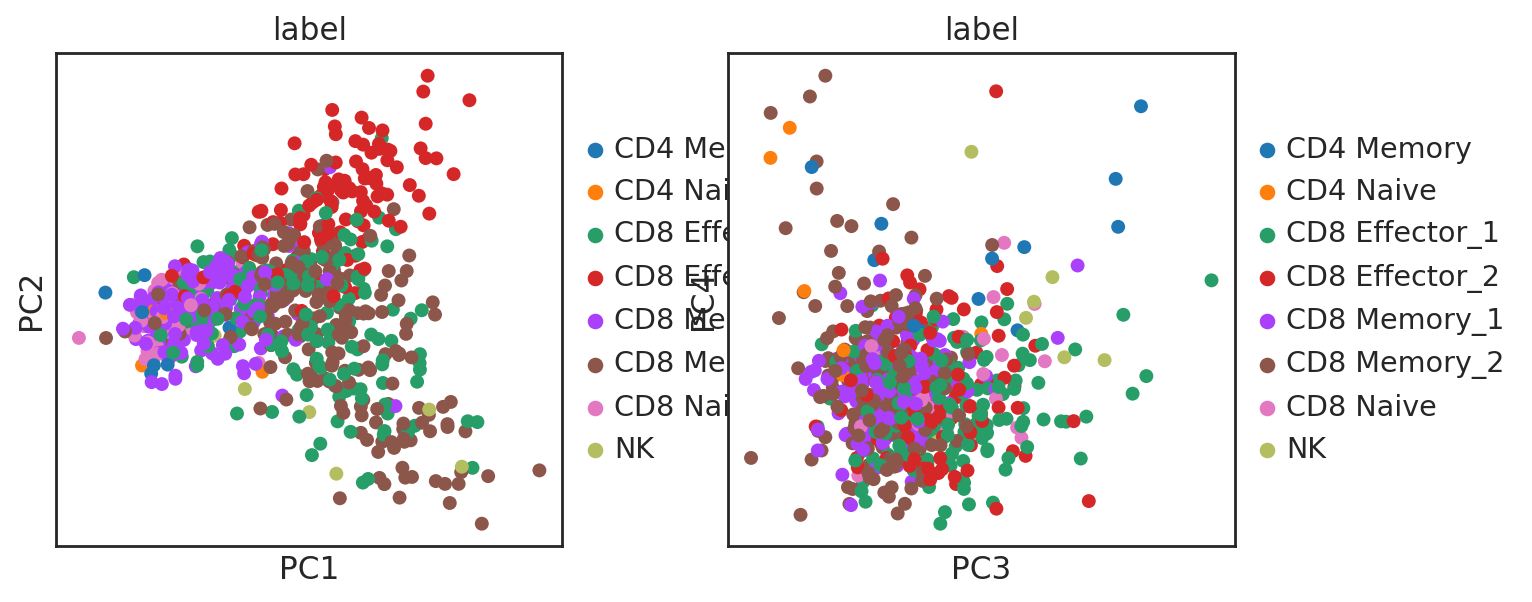

In [100]:
adata_sub = adata[node.indices,:].copy()
from sklearn import preprocessing

adata_sub.obs['label'] = adata_sub.obs['label'].astype(str)
# adata_sub.X = preprocessing.scale(adata_sub.X)
sc.pp.scale(adata_sub, max_value=10, zero_center=False)
sc.tl.pca(adata_sub)
sc.pl.pca(adata_sub, color='label', components=['1,2','3,4'])
# indices, flag = outlier_filter(pd.DataFrame(adata_sub.obsm['X_pca'][:,:5]))
# print(len(indices)/len(adata_sub))
# adata_sub = adata_sub[indices,:]
# # adata_sub.X = preprocessing.scale(adata_sub.X)
# sc.pp.scale(adata_sub, max_value=10, zero_center=False)
# sc.tl.pca(adata_sub)
# sc.pl.pca(adata_sub, color='label', components=['1,2','3,4'])

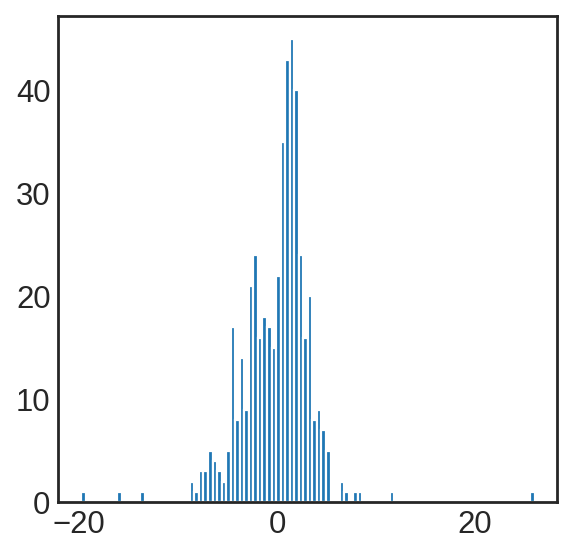

In [120]:
plt.hist(adata_sub.obsm['X_pca'][:,1],bins=100)
plt.show()

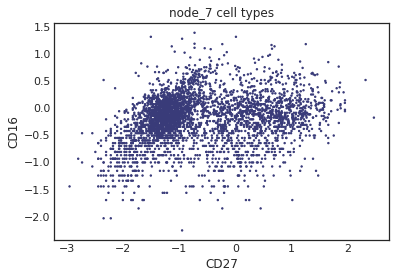

In [ ]:
traversal.plot_node_2dim_new(adata, 7, 'CD27', 'CD16')
# traversal.plot_node_2dim_new(data, 20, 'CD8a', 'CD4')
# traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD19')

## Stop early

In [37]:
ind=0
def finetune_dfs(node, cutID, cut=False):
    node.ind = [i for i in range(len(traversal.nodename)) if len(traversal.nodelist[i].indices)==len(node.indices)][0]
    print(node.ind,node.key)
    if node.key == ('leaf',):
        if cut == True:
            node.key = ('cutleaf',)
        return node       
    else:
        if cut:
            node.key = ('cutleaf',)
        if node.ind in cutID:
            node.key = ('leaf',)
            cut = True
            print('newleaf',node.ind)
        
        
        node.left = finetune_dfs(node.left, cutID, cut=cut)
        node.right = finetune_dfs(node.right, cutID, cut=cut)
        return node

In [102]:
newtree = finetune_dfs(tree, [15,25])
f = open('../output/'+id+'_rna/cuttree.pickle','wb')
pickle.dump(newtree,f)
f.close()

newtravel = BTreeTraversal(newtree)
newleaf = newtravel.get_leaf_label()
# leaves_labels = newtravel.get_leaf_label()
newleaf.to_csv('../output/'+id + '_rna/cut_leaf_labels.csv')
# visualize_tree(newtree,adata,'../output/3_2_/','cuttree',compact=True)

0 ('CD27',)
1 ('CD3',)
3 ('CD4',)
7 ('CD45RO', 'CD69')
13 ('PC0', 'PC1')
19 ('leaf',)
20 ('leaf',)
14 ('leaf',)
8 ('CD45RO', 'CD45RA')
15 ('PC0', 'PC1')
newleaf 15
21 ('leaf',)
22 ('leaf',)
16 ('leaf',)
4 ('CD19',)
9 ('leaf',)
10 ('leaf',)
2 ('CD14',)
5 ('CD19',)
11 ('CD3',)
17 ('CD4',)
23 ('CD69', 'CD45RA')
27 ('leaf',)
28 ('leaf',)
24 ('leaf',)
18 ('CD16',)
25 ('PC0',)
newleaf 25
29 ('PC0', 'PC3')
33 ('leaf',)
34 ('leaf',)
30 ('leaf',)
26 ('CD4',)
31 ('leaf',)
32 ('leaf',)
12 ('leaf',)
6 ('leaf',)


In [165]:
newtravel.nodename

['0_PC0',
 '1_PC0',
 '2_PC0',
 '3_leaf',
 '4_leaf',
 '5_PC0',
 '6_leaf',
 '7_leaf',
 '8_leaf',
 '9_cutleaf',
 '10_cutleaf',
 '11_cutleaf',
 '12_cutleaf',
 '13_cutleaf',
 '14_cutleaf']

In [5]:
nodeID = [14,22]
nodelist, leaves_labels = traversal.get_leaf_label(finetune=True, method='bfs',nodeID=nodeID)
# leaves_labels.to_csv('../output/'+id+'_rna/cut_leaf_labels.csv')
adata.obs['cutpred'] = leaves_labels['Label']

In [6]:
sc.tl.pca(adata,n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
pred_rna = pd.read_csv('../output/'+id+'_rna/leaf_labels.csv',index_col=0)
pred_rna.index  = pred_rna.index.astype(str)
adata.obs['pred_rna'] = pred_rna['Label']

2023-05-28 21:05:34.064494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 21:05:34.211888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-28 21:05:34.211930: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-28 21:05:34.769793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

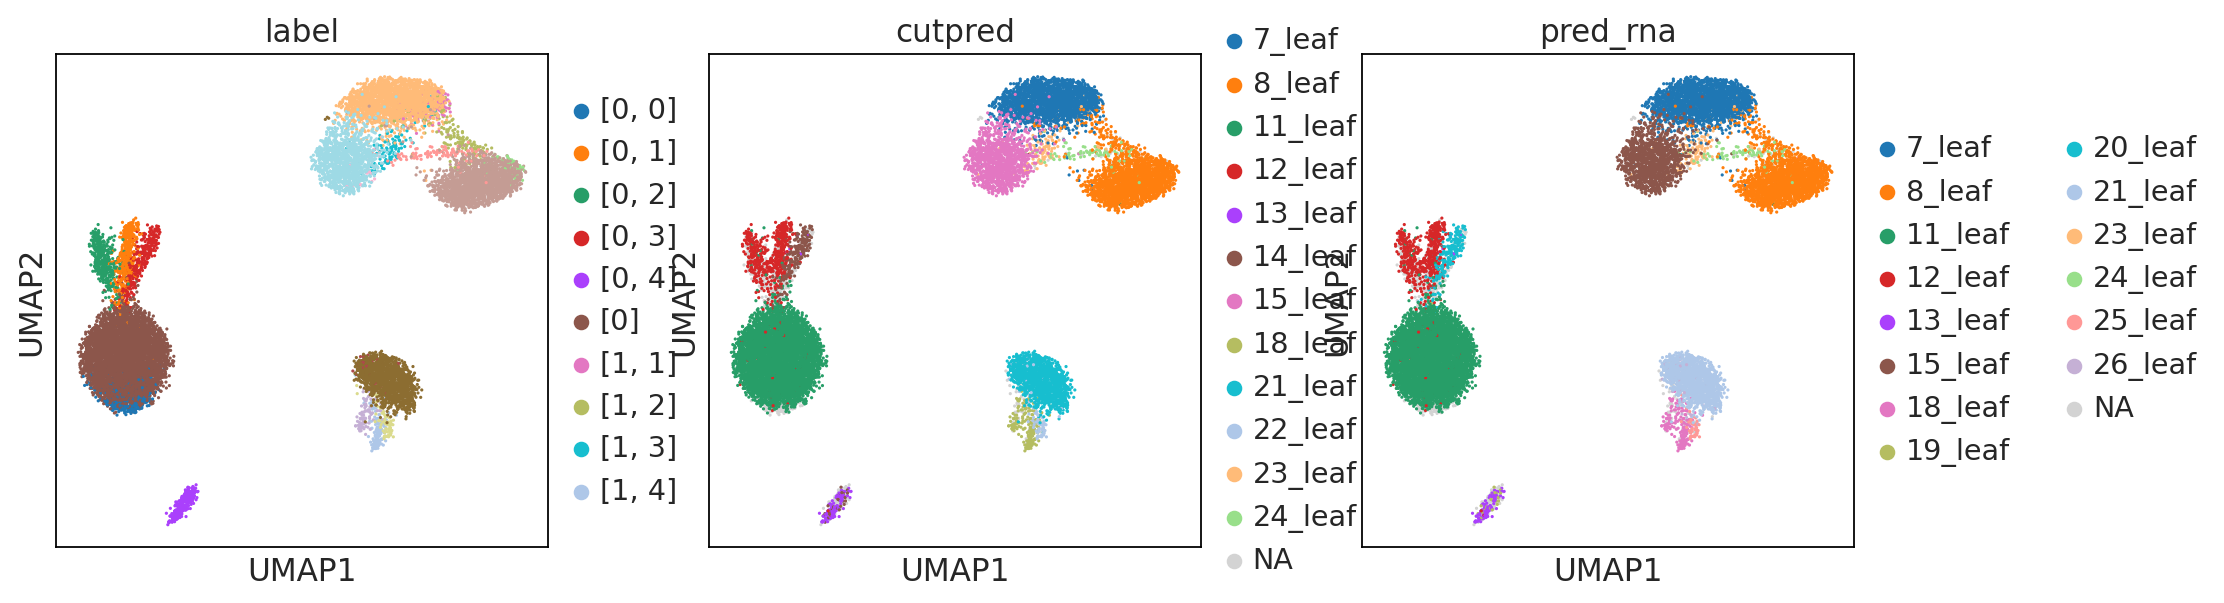

In [8]:
sc.pl.umap(adata,color=['label','cutpred','pred_rna'])

## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

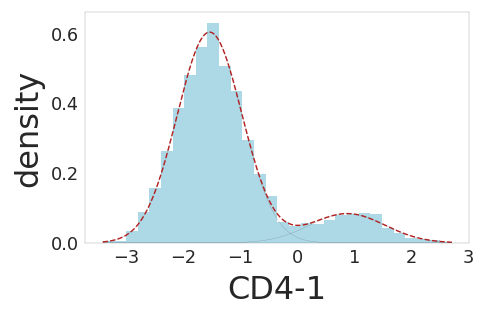

In [ ]:
plot_keymarker(data,traversal,node_ID=2,dpi=128)

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np

def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None):
    # print(cov_list)
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print(i)
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            
            # print([cov_list[i][j,j] for j in range(len(cov_list[i]))])
            # print(sample.loc[:,marker_list[i]])
            # print(mean_list[i])
            # print(cov_list[i])
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list[i]]), mean=np.array(mean_list[i]), cov=np.array(cov_list[i]))   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    # print(p_prior[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)
    return pred_label

In [ ]:
leaf_list = traversal.nodelist.copy()
leaf_list.pop(0)
leaf_list.pop(0)
leaf_list.pop(1)

In [ ]:
node = traversal.get_node(3)
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list]
simulator = pd.read_csv('../simulator/ADT_simulator_9_10.csv', sep=',', index_col=0, header=0)
raw_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8'])
add_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8','CD3-1'])
#### 尝试用所有cutof<0.5的feature来assign，相当于是一个高维的gate

<AxesSubplot:>

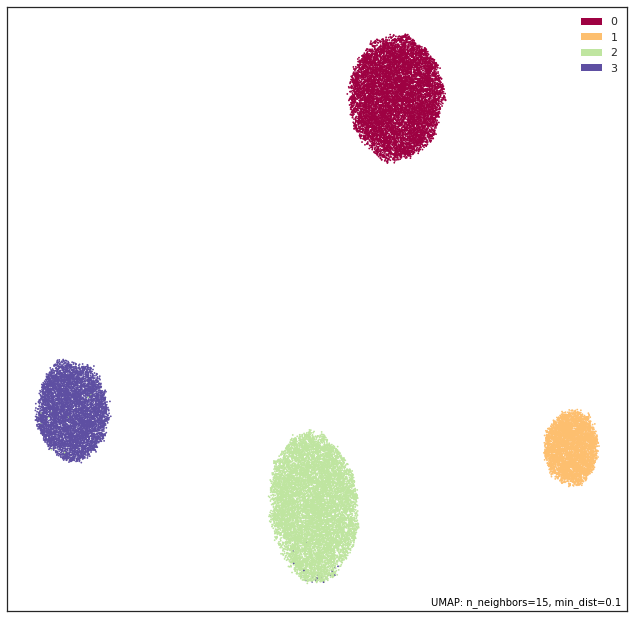

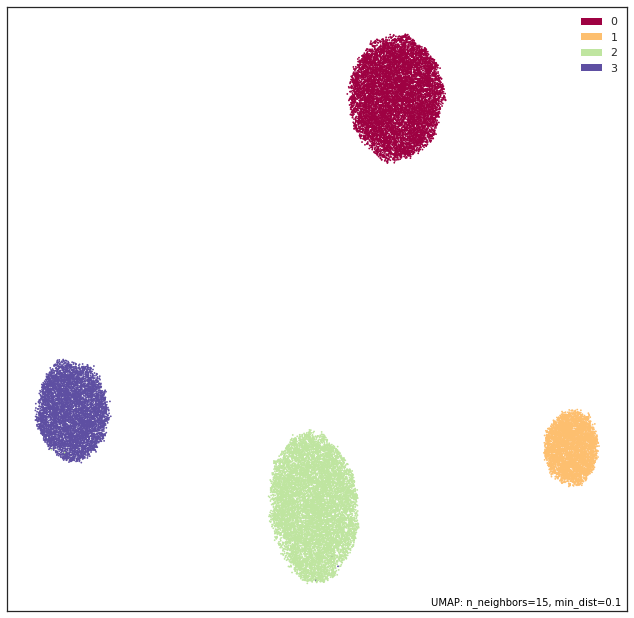

In [ ]:
import umap
import umap.plot
import matplotlib.pyplot as plt

mapper = umap.UMAP().fit(simulator)
umap.plot.points(mapper, labels=raw_label)
umap.plot.points(mapper, labels=add_label)

In [ ]:
raw_label.iloc[20675:].value_counts()
# add_label.iloc[20675:].value_counts()

2    9851
3      21
dtype: int64

In [ ]:
# add_label.index = simulator.index
simulator[raw_label==3].to_csv('../simulator/ADT_simulator_9_11.csv')

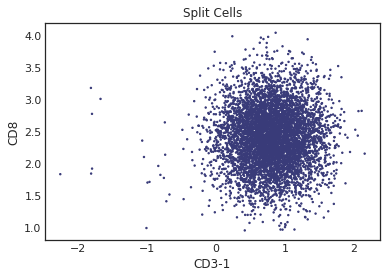

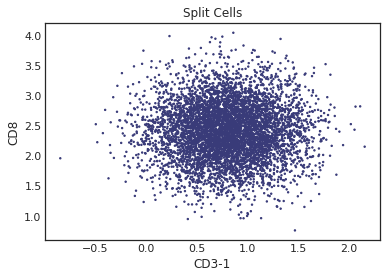

In [ ]:
from CITEsort.Visualize import visualize_2dim

visualize_2dim(simulator[raw_label==3]['CD3-1'],simulator[raw_label==3]['CD8'],raw_label[raw_label==3])
visualize_2dim(simulator[add_label==3]['CD3-1'],simulator[add_label==3]['CD8'],add_label[add_label==3])

In [ ]:
keys = []
for i in range(28):
    node = traversal.get_node(i)
    if list(node.key) != 'leaf':
        print(node.key)

('CD26-1',)
('IgD',)
('CD26-1',)
('leaf',)
('CD72',)
('CD4-1',)
('CD4-1',)
('CD27', 'CD8a')
('CD8a',)
('leaf',)
('CD244',)
('CD4-1',)
('leaf',)
('CD27',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('CD244',)
('leaf',)
('leaf',)
('CD158', 'CD21')
('CD3-1',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)


In [ ]:
'IgD',
'CD26-1',
'CD72',
'CD4-1',
'CD27', 'CD8a
'CD8a',
'CD244',
'CD4-1',
'CD27',
'CD244',
'CD158', 'CD21',
'CD3-1'

TypeError: unhashable type: 'list'